# Sentence Transformer 란?

[Sentence-BERT](https://arxiv.org/abs/1908.10084) 는 EMNLP 2019 에 제출되었습니다. 꾸준하게 모델을 발전시키고 있으며, 구현체는 [Sentence-Transformer](https://github.com/UKPLab/sentence-transformers) 에 있습니다. 독일에 있는 다름슈타트 공과대학교의 Nils Reimers 와 Iryna Gurevych 에 의해 쓰여졌습니다. 

Sentence-Transformer 란 sentence 나 Paragraph 에 대해서 dense vector representation 을 쉽게 계산해낼 수 있는 방법을 제공해주는 framework 입니다. 흔히 sentence embedding 이라고 불리죠. 이 모델은 Transformer 에 기반을 두고 있으며, 특히 비슷한 의미를 가진 문장을 vector space 에서 가깝게 묶어줄 수 있는 등의 의미있는 sentence embedding 을 찾아내는데 특화되어 있습니다. 

Sentence-BERT 의 논문을 잠시 살펴보면, BERT 의 구조상의 문제 때문에 STS(semantic textual similarity) 와 같은 작업을 할 때 Computation overhead 가 심하다고 이야기 합니다. 10000개의 sentence 가 있을 때 50-million inference (65시간) 이 걸린다고 하죠. 그래서 Sentence-BERT 는 siamese 과 triplet network 를 cosine-similarity 와 함께 사용함으로써 65시간을 5초로 줄였다고 말합니다. 기본적으로 BERT 를 기반으로 하지만 Training 할 때 RoBERTa 를 기반으로도 해보니 더 동작을 잘하는 경우가 많다고 합니다.
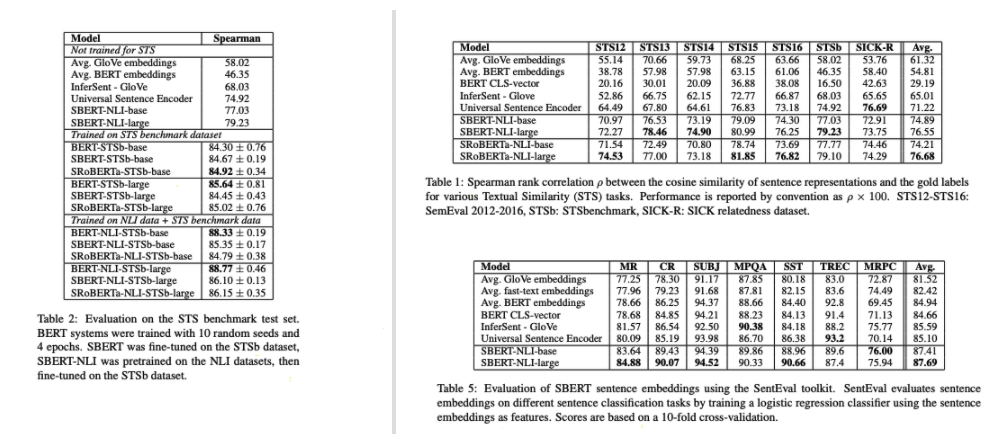

In [ ]:
!pip3 install sentence_transformers

# Background

이 과제를 진행하기 전에 알아두어야 할 개념들이 좀 있을 것 같습니다.
- Siamese and triplet network

# 데이터 EDA (간단하게만 봅시다)

In [ ]:
import glob
zipfiles = glob.glob('../input/spooky-author-identification/*')

In [ ]:
import zipfile
for zipped in zipfiles:
    with zipfile.ZipFile(zipped, 'r') as zip_ref:
        zip_ref.extractall('/kaggle/working/')

In [ ]:
import pandas as pd 
train = pd.read_csv('/kaggle/working/train.csv')
test = pd.read_csv('/kaggle/working/test.csv')
sample_submission = pd.read_csv('/kaggle/working/sample_submission.csv')

In [ ]:
train.head()

# 학습을 위한 데이터셋 생성 - STS

[STS 작업](https://github.com/UKPLab/sentence-transformers/blob/master/examples/training/sts/training_stsbenchmark.py)을 위해서 우리는 label 을 선언하고 해당 label 에 맞는 데이터 셋을 만들어주어야 합니다.
기본적으로 다음과 같은 데이터셋을 사용합니다.

| sid | score | text1 | text2|
| --- | --- | ---| --- |
|0001|5.000|A plane is taking off.|An air plane is taking off.|
|0018|4.600|A woman picks up and holds a baby kangaroo.|A woman picks up and holds a baby kangaroo in her arms.|
|0026|0.500|A woman is writing.|A woman is swimming.|

두 개의 텍스트와 점수에 대해서 설명해주면 될 것 같습니다. 점수가 좀 애매하긴 하지만.. 일단 서로 같은 작가에게서 나온 text 의 경우 1점, 그렇지 않다면 0점을 줘보도록 하죠.

학습에서는 Text 2개를 묶어서 InputExample 로 만들고, label 을 점수로 주면 되는 것 같습니다.
```
train_examples = [InputExample(texts=['My first sentence', 'My second sentence'], label=0.8),
    InputExample(texts=['Another pair', 'Unrelated sentence'], label=0.3)]
```

작가 별로 문장을 묶어줍니다.

In [ ]:
import collections
authors = train.author.unique()
author_idx_to_name = {idx:author for idx, author in enumerate(authors)}
author_name_to_idx = {author:idx for idx, author in enumerate(authors)}
author_to_text_df = train.groupby('author')

author_to_text = collections.defaultdict(list)
for author in authors:
    author_to_text[author] = list(author_to_text_df.get_group(author).text)
    print(f'Author {author} sentence count: {len(author_to_text[author])}')

묶인 문장으로 데이터셋을 만들어보죠!

In [ ]:
import random
from typing import List

from sentence_transformers import InputExample

def make_random_sample() -> InputExample:
    cur_author = author_idx_to_name[random.randrange(0,2)]
    target_author = author_idx_to_name[random.randrange(0,2)]
    score = 1.0 if cur_author == target_author else 0.0

    text1 = random.choice(author_to_text[cur_author])
    text2 = random.choice(author_to_text[target_author])
    
    return InputExample(texts=[text1,text2], label=score)

def make_N_random_samples(N:int) -> List[InputExample]:
    return [make_random_sample() for _ in range(N)]

In [ ]:
for sample in make_N_random_samples(3):
    print(sample)

In [ ]:
samples = make_N_random_samples(3000)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_valid = train_test_split(samples, shuffle=False, test_size=0.2)

학습용 데이터를 만들었으니, 학습을 시작해봅시다.
현재 distilbert-base-uncased 로 모델을 학습하면 [ISSUE - Problems on training models with NLI](https://github.com/UKPLab/sentence-transformers/issues/642) 문제가 발생하고 있어서 모델을 바꿔주었습니다.

In [ ]:
import datetime

from sentence_transformers import models, SentenceTransformer

train_batch_size = 16
num_epochs = 1
model_save_path = '/kaggle/working/sts'

model_name = 'bert-base-uncased' # 'distilbert-base-uncased'
word_embedding_model = models.Transformer(model_name)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),
                              pooling_mode_mean_tokens=True,
                              pooling_mode_cls_token=False,
                              pooling_mode_max_tokens=False)

model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

학습시 Accelerator 별로 iteration 당 시간이 많이 다릅니다.
GPU 의 경우 4~5 it/s 정도 나오는 것으로 보이네요. 일단 3만개정도 sample 을 만들어두고 테스트를 진행하였습니다.

In [ ]:
import math

from torch.utils.data import DataLoader
from sentence_transformers import evaluation, losses, models, readers

train_dataloader = DataLoader(X_train, shuffle=True, batch_size=train_batch_size)
train_loss = losses.CosineSimilarityLoss(model=model)
# train_loss = losses.

evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(X_valid, name='sts-val')
warmup_steps = math.ceil(len(train_dataloader) * num_epochs  * 0.1)

history = model.fit(train_objectives=[(train_dataloader, train_loss)],
         evaluator=evaluator,
         epochs=num_epochs,
         evaluation_steps=10,
         warmup_steps=warmup_steps,
         output_path=model_save_path)

In [ ]:
dir(evaluator)

학습을 시켰으면 항상 어떤 방식으로 학습이 되었는지 확인해야 합니다.
sentence transformer 의 경우에는 evaluator 가 값을 저장해주는데요, 값은 다음과 같이 여러개가 나옵니다. 여러 값들이 증가하는 것을 보니 적당히 학습이 잘 되고 있는 것으로 보이긴하네요.

|epoch|steps|cosine_pearson|cosine_spearman|euclidean_pearson|euclidean_spearman|manhattan_pearson|manhattan_spearman|dot_pearson|dot_spearman|
|---|---|---|---|---|---|---|---|---|---|
|0|-1|0.6756916953552541|0.6724813262104863|0.660390593215294|0.6598554604407646|0.6612042285130364|0.6618763688337842|0.6555369090778884|0.6709608332290717|
|0|10|0.6082673978938935|0.5986315595055741|0.6051428968185604|0.5984583387861725|0.5977919825547264|0.5930500029915202|0.5976140438592621|0.5980926506007689|
|0|20|0.39323089013844387|0.4232359577380823|0.4287428438486719|0.4389605497104339|0.43034954944536175|0.4406350166646501|0.4023881689158198|0.41188037724397275|
|0|30|0.5040527717209264|0.4992221133156153|0.5088837269793809|0.5043225011646644|0.5069644172875665|0.49935684054181656|0.47457684317085097|0.48477743672521456|
|0|40|0.6016725586702936|0.5977654559085657|0.5840104207868922|0.580481877461599|0.5831427450319251|0.5793655661587882|0.5729372315816345|0.5924148603537142|
|0|50|0.6426686266828041|0.6445927903868174|0.6384679535311004|0.637702455103951|0.6396017230334358|0.6384145847281578|0.6393529341763999|0.6452279330246236|
|0|60|0.6521919079854688|0.6503475676202729|0.6479287843282486|0.6465367117934362|0.6470385165975707|0.6456321147032275|0.6403001059263043|0.6457283484362283|
|0|70|0.6708212464147971|0.6708645994960707|0.6710047669598946|0.6691516390486543|0.6704881212665247|0.6690554053156533|0.6591215040789664|0.6622228102725874|
|0|80|0.6888355087909872|0.6874168015722304|0.6848255366817957|0.6832979977997906|0.6852242613363551|0.6841448546501989|0.6871758274883415|0.6880134507168362|
|0|90|0.6934238497557352|0.6902845668156581|0.6844889659392809|0.6826436084153844|0.6853504917471167|0.6843180753696005|0.68935116922097|0.6922477349688769|
|0|100|0.6986974889612128|0.6944803575744986|0.6952887450176597|0.6918435532902731|0.6947250211716414|0.6912469041456674|0.6892915062217797|0.6898803851370542|
|0|110|0.7223645164252894|0.7156902723279032|0.7097669838397354|0.7052585356706026|0.7102827633382662|0.7056242238560061|0.7116792899580481|0.7180191286665256|
|0|120|0.738765021272977|0.7293939559072353|0.7243751960042446|0.718153855892727|0.7250349668434091|0.7192509204489375|0.7268326897719134|0.731857539472059|
|0|130|0.7455995445460433|0.7347830449552872|0.7328908164559738|0.7254868663473977|0.7334885752404563|0.7260257752522029|0.734307724963617|0.737747043931716|
|0|140|0.7478402644215782|0.7370926545473097|0.7344804600309588|0.7283738783374255|0.7352668558630759|0.7291052547082325|0.7342538978160011|0.7398834328043365|
|0|150|0.7485007383776441|0.7372658752667113|0.7350025504865526|0.7289320339888309|0.7358013230784056|0.7293362156674349|0.7344982474442316|0.7402876144829403|
|0|-1|0.7485007383776441|0.7372658752667113|0.7350025504865526|0.7289320339888309|0.7358013230784056|0.7293362156674349|0.7344982474442316|0.7402876144829403|


In [ ]:
model = SentenceTransformer(model_save_path)
model

학습이 다 되었다면 이제는 어떤 author 가 쓴 글귀인지 알아차리는게 필요한데, 일단 어떻게 할지 잘 모르겠으니 각 author 별로 1개씩 random 하게 문장을 가져온 뒤에, 문장 별 score 를 구하고 가장 높은 score 를 뱉는 문장의 author 를 결과라고 생각해봅니다.

In [ ]:
sampled_texts = []
for author in authors:
    text = random.choice(author_to_text[author])
    print(f'text: {text}')
    sampled_texts.append(text)

test 와 random sample 들 간의 점수를 얻어봅니다. EmbeddingSimilarityEvaluator 를 통해서 점수를 구해보려고 했으나 모델을 바꿔보아도 같은 에러가 발생해서 다른 방법을 찾아보고자 합니다. [EmbeddingSimilarityEvaluator](https://github.com/UKPLab/sentence-transformers/blob/master/sentence_transformers/evaluation/EmbeddingSimilarityEvaluator.py)의 내부를 살펴보면 model.encode 를 사용해서 embedding 을 구해서 score 를 구해내는 것을 볼 수 있습니다.

In [ ]:
# Error 발생. - PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
# from sentence_transformers import evaluation
# test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_samples, name='sts-test', show_progress_bar=True)
# test_evaluator(model, output_path=model_save_path)

In [ ]:
from sklearn.metrics.pairwise import paired_cosine_distances
test_texts = list(test.text)
embedding_test = model.encode(test_texts)

In [ ]:
print(len(list(test.text)))
print(embedding_test.shape)
print(len(sampled_texts))

In [ ]:
cosine_scores = []
for idx, text in enumerate(sampled_texts):
    embedding_target = [model.encode(text)] * len(test.text)
    cosine_scores.append(1 - (paired_cosine_distances(embedding_test, embedding_target)))

In [ ]:
import numpy as np
from scipy import special
cosine_scores = special.softmax(np.asarray(cosine_scores), axis=0)
cosine_scores = cosine_scores.reshape(-1, 3)

In [ ]:
from scipy import special

score_df = pd.DataFrame(cosine_scores)
print(score_df)
score_df = score_df.rename(columns=author_idx_to_name)
score_df.insert(0, 'id', test.id, True)
print(score_df)
score_df.to_csv('/kaggle/working/submission.csv', index=False)

학습을 할수록 loss 가 높아지는 것 같은 느낌..? 
작가별 문장을 구분하기 위해서 sentence bert 와 같이 의미보다는 작가의 필체를 알아내는 작업은 좋지 않은 성능을 내는 것 같습니다.

# 학습을 위한 데이터 생성 - NLI

Natural Language Interface (자연어 추론)라고 불리는 Task 인데, text 의 사이가 entailment, contradiction, neutral 인지 판별해내는 것으로 recognizing textual entailment(RTE) 라고도 알려져 있습니다. 대중적인 NLI 데이터셋에는 SNLI AINLI 와 같은 데이터셋이 존재합니다. 위의 STS (텍스트의 의미적 유사성) 과 비슷한 과제로 보입니다.

[KorNLI, KorSTS 를 소개하는 사이트](https://catsirup.github.io/ai/2020/04/20/KorNLI_and_KorSTS-copy.html) 를 보면 다음과 같이 말씀하시네요.

STS
- 두 문장 사이의 의미적 유사성과 그래프를 평가하는 과제. 유사성 점수는 0부터 5까지 매기며 숫자가 클 수록 의미가 가깝다고 본다.
- 모델이 의미상 두 문장의 친밀도를 얼마나 잘 잡아내는지 또는 문장의 의미적 표현을 얼마나 잘 구현하는지 평가하는데 일반적으로 사용된다.

NLI
- 시스템은 한 쌍의 문장, 전제와 가설을 받고 그 관계를 얽힘(entailment), 모순(contradiction), 중립(neutral) 중 하나로 분류.

NLI 로 author 들의 전제 문장 1개씩을 뽑고 test 문장과의 관계를 분류해내고자 했는데 이게 말이 되는건지 모르겠네요. 사실 STS 로도 작가별 문장을 뽑아서 비교할때 문장의 의미라기 보다는 어떤 작가의 것인가를 판별하기 위해 사용해봤는데 그것도 잘 안됐거든요. 일단 학습해보려다가 포기. ㅎㅎ; 다른 분들의 작업들을 보고 다시오겠습니다.


In [ ]:
author_to_text

In [ ]:
import random
from typing import List

from sentence_transformers import InputExample

def make_random_sample_nli() -> InputExample:
    cur_author = random.randrange(0,2)
    
    text1 = random.choice(author_to_text[author_idx_to_name[cur_author]])
    text2 = random.choice(author_to_text[author_idx_to_name[cur_author]])
    
    return InputExample(texts=[text1, text2], label=cur_author)

def make_N_random_samples_nli(N:int) -> List[InputExample]:
    return [make_random_sample_nli() for _ in range(N)]

In [ ]:
for sample in make_N_random_samples_nli(3):
    print(sample)

In [ ]:
samples_nli = make_N_random_samples_nli(30000)

In [ ]:
from sklearn.model_selection import train_test_split

X_nli_train, X_nli_valid = train_test_split(samples, shuffle=False, test_size=0.2)

In [ ]:
# import datetime

# from sentence_transformers import models, SentenceTransformer

# train_batch_size = 16
# num_epochs = 1
# model_save_path_nli = '/kaggle/working/nli'

# model_name = 'bert-base-uncased' # 'distilbert-base-uncased'
# word_embedding_model_nli = models.Transformer(model_name)
# pooling_model_nli = models.Pooling(word_embedding_model.get_word_embedding_dimension(),
#                               pooling_mode_mean_tokens=True,
#                               pooling_mode_cls_token=False,
#                               pooling_mode_max_tokens=False)

# nli_model = SentenceTransformer(modules=[word_embedding_model_nli, pooling_model_nli])

# nli_train_dataloader = DataLoader(X_nli_train, shuffle=True, batch_size=train_batch_size)
# nli_train_loss = losses.SoftmaxLoss(model=nli_model, sentence_embedding_dimension=nli_model.get_sentence_embedding_dimension(), num_labels=len(author_name_to_idx))

In [ ]:
# import math

# from torch.utils.data import DataLoader
# from sentence_transformers import evaluation, losses, models, readers

# nli_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(X_valid, name='nli-val')
# nli_warmup_steps = math.ceil(len(train_dataloader) * num_epochs  * 0.1)

# nli_model.fit(train_objectives=[(nli_train_dataloader, nli_train_loss)],
#          evaluator=nli_evaluator,
#          epochs=num_epochs,
#          evaluation_steps=1000,
#          warmup_steps=warmup_steps,
#          output_path=model_save_path_nli)

In [ ]:
# 학습을 위한 데이터 생성 - Find similar text